In [1]:
%matplotlib inline
#some basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from IPython.display import display

#TODO: add your imports here
from elasticsearch import Elasticsearch
from matplotlib.lines import Line2D

#seting up some styles
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

experiment_name = "DITAS-Performance-Benchmark"

#getting data
from load import load_elastic,load_experiment,load_vmstat,load_rmstats,_load_vmstat
use_cache=False
load_from_disk = False

es = Elasticsearch(host="153.92.30.56",
                   http_auth=('admin', 'ditasmetrics'),
                   scheme="http",
                   port=50035)

In [135]:
to_download = [pd.Timestamp("2019-12-18")]
mon__cache_file="rmstats/rmstats_{}.csv".format(datetime.now().strftime("%d-%m-%Y"))
esData = load_elastic(False,True,mon__cache_file,es,to_download)

loading data from index *-2019-12-18


In [136]:
data_cache_file="{}_{}.data.csv".format(experiment_name,datetime.now().strftime("%d-%m-%Y"))
data = load_experiment(use_cache,True,data_cache_file)


experiment_dates =list(map(lambda x:pd.Timestamp(x),data['runDate'].unique()))
esData = load_rmstats()

vstat__cache_file="{}_{}.vmstat.csv".format(experiment_name,datetime.now().strftime("%d-%m-%Y"))
vsData = load_vmstat(use_cache,True,vstat__cache_file)

esData["timestamp"] = pd.to_datetime(esData["@timestamp"],format='%Y-%m-%dT%H:%M:%S.%f',utc=True)
esData["timestamp"] = esData["timestamp"].dt.ceil(freq='s')  
esData["timestamp"] = esData["timestamp"].dt.tz_convert(None)

data["timestamp"] = data["startTime"]+data["offset"].astype(int).apply(lambda x:pd.Timedelta(seconds=x))
vsData["timestamp"] = vsData["timestamp"] -pd.Timedelta(seconds=3600)

In [3]:
def load(subjects,offset):
    #select the exp we want to look at
    exp = data[data["experiment"].isin(subjects)]
    #remove data not from that exp
    EStart,EEnd = exp["timestamp"].min(),exp["timestamp"].max()
    expVMStats = vsData[vsData["timestamp"].between(EStart,EEnd)]
    expRMStats = esData[esData["timestamp"].between(EStart,EEnd)]
    
    #remove timeout errors (timeout of client is 120)
    exp = exp[exp["response-time"] < 120]

    #create a copy to work with and normilize the time across each view
    exp = exp.copy()
    expVMStats = expVMStats.copy()
    expRMStats = expRMStats.copy()
    exp["ETime"] = exp["timestamp"]-EStart
    expVMStats["ETime"] = expVMStats["timestamp"]-EStart
    expRMStats["ETime"] = expRMStats["timestamp"]-EStart+pd.Timedelta(seconds=offset)

    exp["ETime"] = exp["ETime"].apply(lambda x:x.total_seconds())
    expVMStats["ETime"] = expVMStats["ETime"].apply(lambda x:x.total_seconds())
    expRMStats["ETime"] = expRMStats["ETime"].apply(lambda x:x.total_seconds())
    
    return exp,expVMStats,expRMStats

def plot(subjects,name,offset,statistics,show_vrrl=True):  

    exp,expVMStats,expRMStats = load(subjects,offset)
    
    exp["sliceID"] = np.round(exp["ETime"]/slice_size)
    client_view = exp.groupby("sliceID")["response-time","size"].agg(["min","max","mean","sum"])
    
    if len(expRMStats) > 0:
        expRMStats["sliceID"] = np.round(expRMStats["ETime"]/slice_size)
        expRMStats["requestTime_sec"] = np.round(expRMStats["request.requestTime"]/1000000000,2)
        vdc_view = expRMStats.groupby("sliceID")["requestTime_sec","response.length"].agg(["min","max","mean","sum"])
    else:
        vdc_view = pd.DataFrame([],columns=pd.MultiIndex(levels=[['requestTime_sec', 'response.length'], ['min', 'max', 'mean', 'sum']],
              codes=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]]))

    expVMStats["sliceID"] = np.round(expVMStats["ETime"]/slice_size)

    
    
    mashine_view = expVMStats.groupby("sliceID")[["cpu_user","free"]].mean()
    
    fig = plt.figure(figsize=(15,6))
    gs = fig.add_gridspec(ncols=3, nrows=1)
    plt.suptitle("{} Results".format(name), fontsize=16,y=0.99)
    ax = fig.add_subplot(gs[0, 0:2])
    ax2 = ax.twinx()
    ax.plot(client_view["response-time"]["mean"],label="CRRL",color=colors["CRRL"],zorder=2)
    ax.fill_between(client_view.index,client_view["response-time"]["min"],client_view["response-time"]["max"],color=colors["CRRL"],alpha=0.4,zorder=1)
    
    if len(vdc_view) > 0 and show_vrrl:
        ax.plot(vdc_view["requestTime_sec"]["mean"],label="VRRL",color=colors["VRRL"],zorder=2)
        ax.fill_between(vdc_view.index,vdc_view["requestTime_sec"]["min"],vdc_view["requestTime_sec"]["max"],color=colors["VRRL"],alpha=0.4,zorder=1)
    
    ax.set_title("Client-View")
    if "size" in client_view:
        ax2.plot(client_view["size"]["mean"]/slice_size,label="Throughput",color=colors["Thr"],zorder=2)
    ax.set_ylabel("Request-Response-Time [s]")
    ax2.set_ylabel("Throughput [bytes/s]")
    ax.set_xlabel("Time [s]")
    ax.set_xticklabels([""])
    legendNames = ["CRRL","VRRL","Throughput"]

    legendShapes = [
            Line2D([0], [0], color=colors["CRRL"], lw=2),
            Line2D([0], [0], color=colors["VRRL"], lw=2),
            Line2D([0], [0], color=colors["Thr"], lw=2)
        ]
    ax.legend(legendShapes, legendNames, fancybox=True, shadow=True)
    ax = fig.add_subplot(gs[0, 2])

    ax2 = ax.twinx()
    ax2.fill_between(mashine_view.index,mashine_view["free"],np.zeros(len(mashine_view["free"])),alpha=0.5,zorder=10,color=colors["MEM"])
    sns.lineplot(mashine_view.index,mashine_view["free"],zorder=10,color=colors["MEM"],ax=ax2)
    sns.lineplot(x=mashine_view.index,y=mashine_view["cpu_user"],ax=ax,color=colors["CPU"],zorder=1,linewidth=2)
    ax.set_ylabel("CPU Usage [%]")
    ax2.set_ylabel("Memory Usage [MB]")
    ax.set_title("VDC-View")
    ax.set_xlabel("Time [s]")
    ax.set_xticklabels([""])
    plt.tight_layout()
    fig.savefig("images/{}.pdf".format(name), bbox_inches="tight")
    fig.savefig("images/{}.png".format(name), bbox_inches="tight")
    if len(vdc_view) > 0:
        transport_latency = exp["response-time"].mean()-expRMStats["requestTime_sec"].mean()
        rmMean = expRMStats["requestTime_sec"].mean()
        p90 = expRMStats["requestTime_sec"].quantile(0.9)
    else:
        transport_latency = float("nan")
        rmMean = float("nan")
        p90 = float("nan")
    
    
    
    df = [name,np.round(transport_latency,2),exp["response-time"].mean(),exp["response-time"].quantile(0.9),rmMean,p90]
    if (statistics is None):
        statistics = [df]
    else:
        statistics.append(df)
    return statistics

In [132]:
colors = {
    "CRRL":"#448ee4",
    "VRRL":"#25a36f",
    "MEM":"#89a203",
    "CPU":"#000000",
    "Thr":"#555555"
}

experiments = {
    "B1":(["B1"],325),
    "B2":(["B3A","B3B"],325),
    "B3":(["B4A","B4B"],325),
    "B5":(["B7"],325),
    "B6":(["B8"],325),
    "B7":(["B6"],325),
    "B8":(["B10"],325),
    "B9":(["B11"],325),
}

slice_size = 60

,name,Mean TL,Mean CRRL,p90 CRRL,Mean VRRL,p90 VRRL
0,B1,0.21,11.683438,18.65126,11.469177,18.320
1,B2,-0.01,5.955982,6.60398,5.970140,6.739
2,B3,0.37,9.206901,13.36830,8.838386,12.706


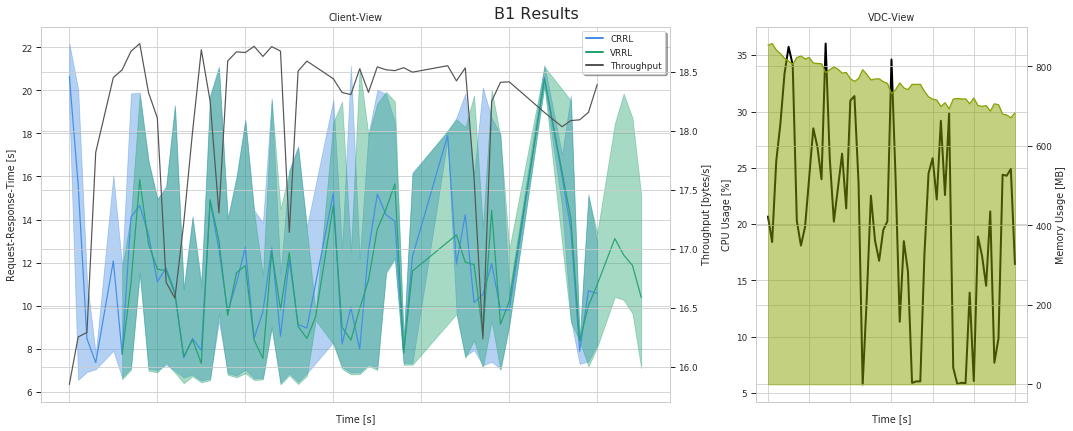

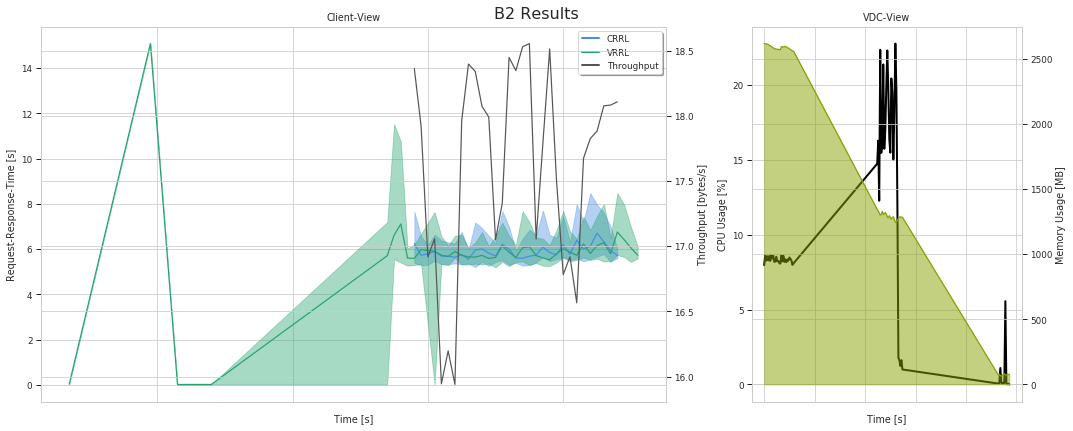

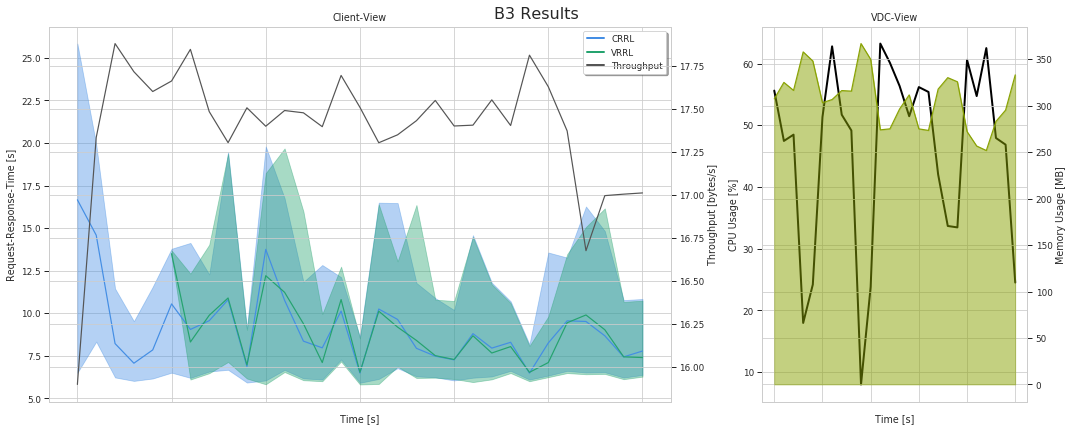

In [137]:
statistics = None
for s in ["B1","B2","B3"]:
    statistics = plot(experiments[s][0],s,experiments[s][1],statistics)
statistics = pd.DataFrame(statistics,columns=["name","Mean TL","Mean CRRL","p90 CRRL","Mean VRRL","p90 VRRL"])
statistics

In [138]:
import math
four_two = {"with":["B2","B7"],"without":["B5","B6"]}
statistics = []
for l in four_two:
    for e in four_two[l]:
        exp,expVMStats,expRMStats = load(*experiments[e])
        a = exp[["status-code","timestamp","ETime","response-time"]]
        r_100 = a["status-code"].count()
        a = a[a["status-code"] == 200][:100]
        start = a["ETime"].min()
        end = a["ETime"].max()
        total_response_time = end-start
        if len(a) == 0:
            total_response_time = 0
        statistics.append([l,e,total_response_time,r_100,a["response-time"].mean()])

statistics = pd.DataFrame(statistics,columns=["type","name","TRT","R100","mean R"])
statistics.groupby("type")["TRT","R100","mean R"].mean()



,TRT,R100,mean R
type,,,
with,612.0,453.5,5.782084
without,528.0,6188.0,7.653289


In [105]:
exp,expVMStats,_ = load(*experiments["B9"])
expVMStats = _load_vmstat(pd.read_csv("vmstats/load_2019_12_17.csv"))
B9 = expVMStats[expVMStats.timestamp.between(exp.timestamp.min()-pd.Timedelta(minutes=3),exp.timestamp.max()+pd.Timedelta(minutes=2))]
B9 = B9.copy()
B9['EStart'] = B9['timestamp']-B9['timestamp'].min()
B9['EStart'] = B9['EStart'].apply(lambda x:x.total_seconds())
#B9[["cpu_user","free"]].agg(["mean","max"])

In [106]:
exp,expVMStats,_ = load(*experiments["B8"])
expVMStats = _load_vmstat(pd.read_csv("vmstats/load_2019_12_17_withMon.csv"))
B8 = expVMStats[expVMStats.timestamp.between(exp.timestamp.min()-pd.Timedelta(minutes=3),exp.timestamp.max()+pd.Timedelta(minutes=2))]
B8 = B8.copy()
B8["cpu_user"] *= 0.25

B8['EStart'] = B8['timestamp']-B8['timestamp'].min()
B8['EStart'] = B8['EStart'].apply(lambda x:x.total_seconds())


In [110]:
B8["slice_id"] = np.round(B8["EStart"]/10)
B8 = B8[B8["slice_id"] < 9]
B9["slice_id"] = np.round(B8["EStart"]/10)
B9 = B9[B9["slice_id"] < 9]

cpu_user     0.921512
free        72.651163
dtype: float64

cpu_user     0.093023
free        76.209302
dtype: float64

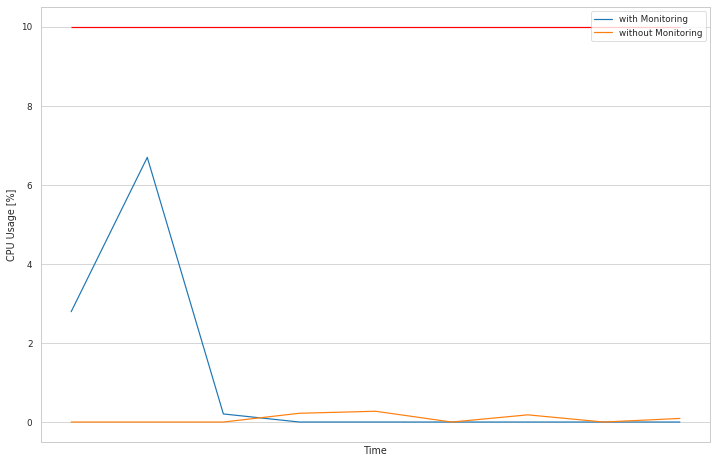

In [131]:
fig, ax = plt.subplots(figsize=(12,8))

X = B8.groupby("slice_id")["cpu_user"].mean()
sns.lineplot(data=X,ax=ax,label="with Monitoring")
Y = B9.groupby("slice_id")["cpu_user"].mean()
sns.lineplot(data=Y,ax=ax,label="without Monitoring")
#sns.lineplot(x="cpu_user",y=range(0,len(B9)),data=B9,ax=ax,label="without Monitoring")
ax.hlines(10,xmin=B9["slice_id"].min(),xmax=B9["slice_id"].max(),label="10% cutoff",color="r")
ax.set_xlabel("Time")
ax.set_xticks([])
ax.set_ylabel("CPU Usage [%]")

X = B8[["cpu_user","free"]].mean()
Y = B9[["cpu_user","free"]].mean()
display(X)
display(Y)